In [23]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Constants
START_DATETIME = dt.datetime(2024, 11, 18, 8, 0, 0)
END_DATETIME = dt.datetime(2025, 1, 9, 8, 0, 0)
TICKER_SYMBOL = "BTC-USD"
INTERVAL = "1h"
LOOK_BACK = 120
EPOCHS = 50
BATCH_SIZE = 16
ITERATIONS = 24

# Fetching data
historical_data = yf.download(
    tickers=TICKER_SYMBOL,
    start=START_DATETIME,
    end=END_DATETIME,
    interval=INTERVAL
)

historical_data.dropna(inplace=True)
closing_prices = historical_data['Close'].values.reshape(-1, 1)
dates = historical_data.index

# Scaling data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

def create_sequences(data, sequence_length=60):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, 0])
        y.append(data[i, 0])
    X = np.array(X)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    y = np.array(y)
    return X, y

X, Y = create_sequences(scaled_data, LOOK_BACK)

# Splitting data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

dates_train, dates_test = dates[LOOK_BACK:train_size+LOOK_BACK], dates[train_size+LOOK_BACK:]

# LSTM model for single-step prediction
model = Sequential([
    LSTM(units=64, return_sequences=True, input_shape=(LOOK_BACK, 1)),
    Dropout(0.2),
    LSTM(units=32, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model
history = model.fit(X_train, Y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, Y_test), verbose=1)

# Iterative forecasting
last_window = X_test[-1].reshape((1, LOOK_BACK, 1))
predictions = []
future_dates = []

for i in range(ITERATIONS):
    pred = model.predict(last_window)
    predictions.append(pred[0][0])
    
    last_window = np.append(last_window[:, 1:, :], pred.reshape(1, 1, 1), axis=1)
    future_dates.append(dates[-1] + pd.Timedelta(hours=i+1))

# Inverse scaling
future_predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

[*********************100%***********************]  1 of 1 completed

Epoch 1/50


57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0415 - val_loss: 0.0033
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0075 - val_loss: 0.0027
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0069 - val_loss: 0.0026
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0058 - val_loss: 0.0025
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0065 - val_loss: 0.0022
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0056 - val_loss: 0.0037
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0059 - val_loss: 0.0025
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0053 - val_loss: 0.0016
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0052 - val_loss: 0.0019
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0046 - val_loss: 0.0016
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0046 - val_loss: 0.0015
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0040 - val_l

In [24]:
# START_DATETIME = dt.datetime(2025, 1, 9, 8, 0, 0)
# END_DATETIME = dt.datetime(2025, 1, 10, 12, 0, 0)
# TICKER_SYMBOL = "BTC-USD"
# INTERVAL = "1h"

In [25]:
# check_data = yf.download(
#     tickers=TICKER_SYMBOL,
#     start=START_DATETIME,
#     end=END_DATETIME,
#     interval=INTERVAL
# )

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


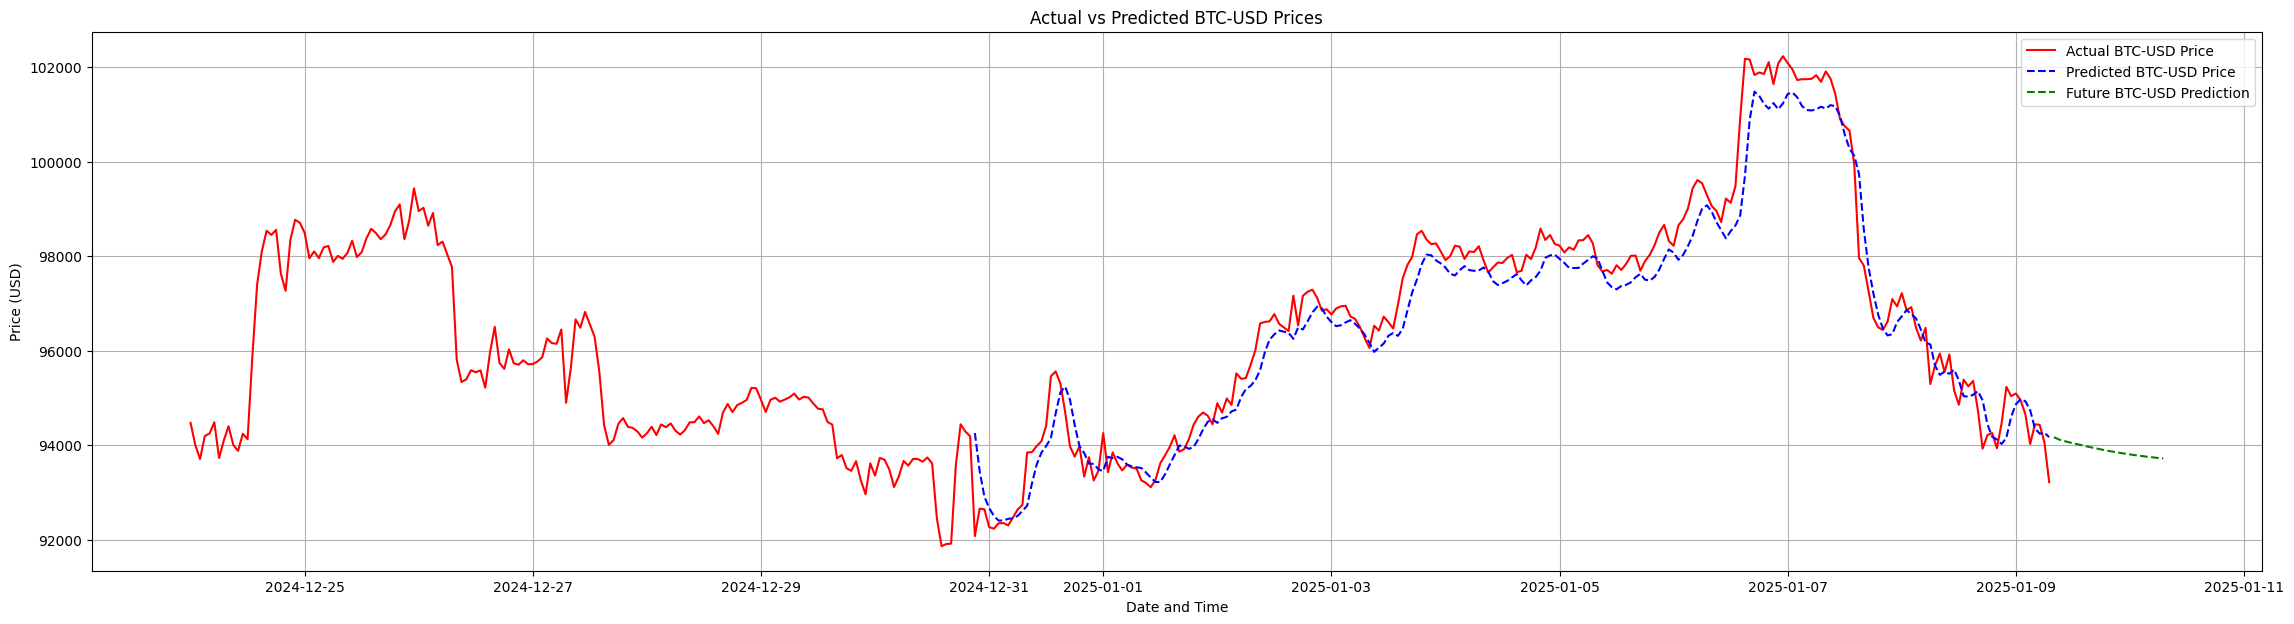

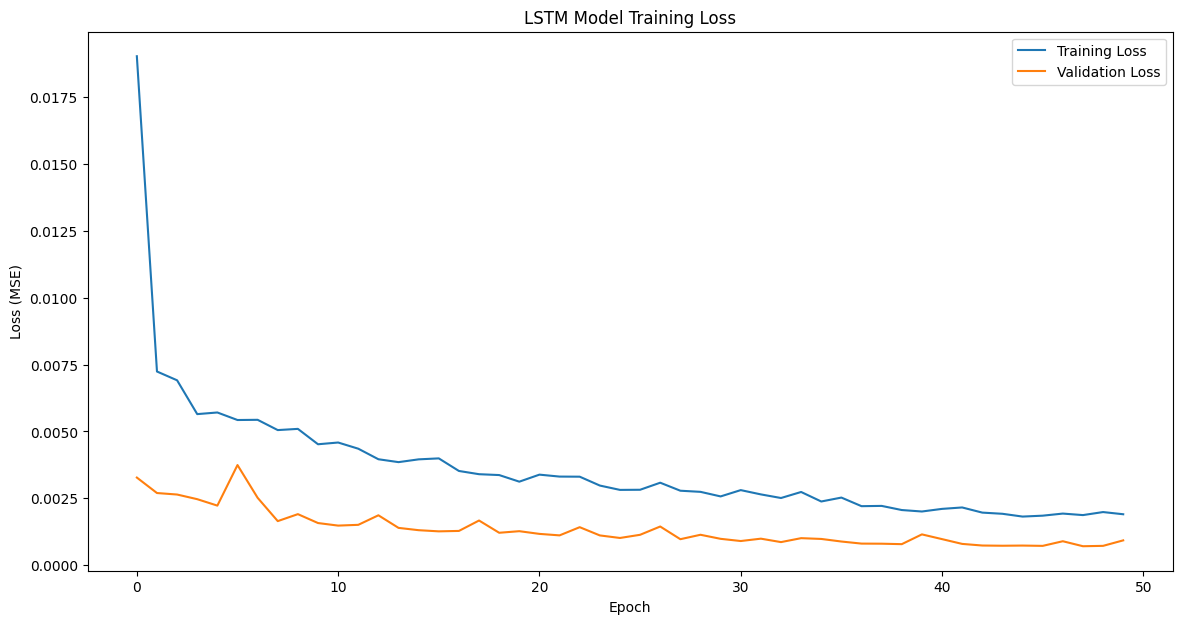

In [26]:
# Plotting results
plt.figure(figsize=(28, 7))

# Actual prices
plt.plot(historical_data.Close[-391:], color='red', label=f'Actual {TICKER_SYMBOL} Price')
#plt.plot(check_data.Close, color='yellow', label=f'Unseen actual {TICKER_SYMBOL} Price')

# Predicted test prices
predicted_prices_test = model.predict(X_test)  # (391, 10)
predicted_prices_test = scaler.inverse_transform(predicted_prices_test)[:, 0]  
plt.plot(dates_test[:len(predicted_prices_test)], predicted_prices_test, color='blue', linestyle='dashed', label=f'Predicted {TICKER_SYMBOL} Price')

# Future predictions
plt.plot(future_dates, future_predictions, color='green', linestyle='dashed', label=f'Future {TICKER_SYMBOL} Prediction')

plt.title(f'Actual vs Predicted {TICKER_SYMBOL} Prices')
plt.xlabel('Date and Time')
plt.ylabel(f'Price (USD)')
plt.legend()
plt.grid()
plt.show()
# Plotting training loss
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()


In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculating MAE and RMSE for test predictions
mae_test = mean_absolute_error(scaler.inverse_transform(Y_test.reshape(-1, 1)), predicted_prices_test)
rmse_test = np.sqrt(mean_squared_error(scaler.inverse_transform(Y_test.reshape(-1, 1)), predicted_prices_test))

print(f'MAE (Test): {mae_test}')
print(f'RMSE (Test): {rmse_test}')


MAE (Test): 438.5825843473452
RMSE (Test): 568.9410940830139


MULTISTEP PREDICTION

In [28]:
def create_multi_step_dataset(dataset, look_back=120, n_steps_ahead=24):
    X, Y = [], []
    for i in range(len(dataset) - look_back - n_steps_ahead):
        X.append(dataset[i : i + look_back, 0])  
        Y.append(dataset[i + look_back : i + look_back + n_steps_ahead, 0])  
    return np.array(X), np.array(Y)

In [29]:
# Scaling data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

LOOK_BACK = 120  # Amount of periods(hours,days etc.) to look back
N_STEPS_AHEAD = 24  # Periods to predict ahead

X, Y = create_multi_step_dataset(scaled_data, LOOK_BACK, N_STEPS_AHEAD)

# Splitting data
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [30]:
def train_multi_step_model(n_steps_ahead):
    model = Sequential([
        LSTM(units=64, return_sequences=True, input_shape=(LOOK_BACK, 1)),
        Dropout(0.2),
        LSTM(units=32, return_sequences=False),
        Dropout(0.2),
        Dense(n_steps_ahead)  
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Training the model
model = train_multi_step_model(N_STEPS_AHEAD)
history = model.fit(X_train, Y_train, epochs=20, batch_size=16, validation_data=(X_test, Y_test), verbose=1)


Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.1649 - val_loss: 0.0117
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0417 - val_loss: 0.0095
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0284 - val_loss: 0.0092
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0219 - val_loss: 0.0083
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0210 - val_loss: 0.0084
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0189 - val_loss: 0.0081
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0172 - val_loss: 0.0103
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0171 - val_loss: 0.0078
Epoch 9/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0152 - val_loss: 0.0078
Epoch 10/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0157 - val_loss: 0.0091
Epoch 11/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0152 - val_loss: 0.0080
Epoch 12/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


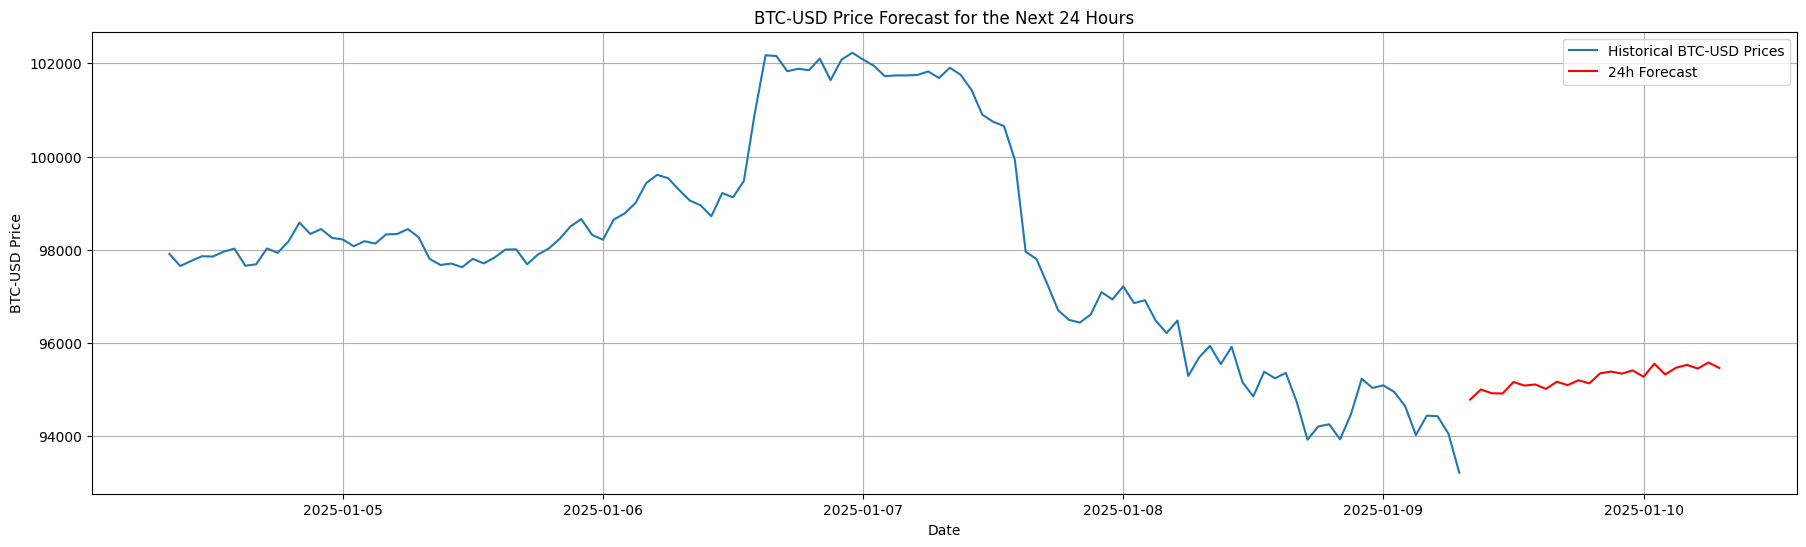

In [35]:
# Fetching the last 120 hourly values
last_window = scaled_data[-LOOK_BACK:].reshape((1, LOOK_BACK, 1))

# Predicting 24 hours ahead
future_prediction_scaled = model.predict(last_window)

# Inverse scaling
future_prediction = scaler.inverse_transform(future_prediction_scaled.reshape(-1, 1))

# Creating dates for the forecast
future_dates = [dates[-1] + pd.Timedelta(hours=i) for i in range(1, N_STEPS_AHEAD + 1)]

# Visualizing the results
plt.figure(figsize=(22, 6))
plt.plot(dates[-120:], closing_prices[-120:], label=f"Historical {TICKER_SYMBOL} Prices")
#plt.plot(check_data.Close, color='yellow', label=f'Actual {TICKER_SYMBOL} Price')

plt.plot(future_dates, future_prediction, color='red', label="24h Forecast")
plt.xlabel("Date")
plt.ylabel(f"{TICKER_SYMBOL} Price")
plt.title(f"{TICKER_SYMBOL} Price Forecast for the Next 24 Hours")
plt.legend()
plt.grid()
plt.show()